# Approach to SARIMA Time Series

In [1]:
#Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt
import pmdarima as pm

from pmdarima.arima.utils import ndiffs

from datetime import datetime

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
#Loading the dataframe
df = pd.read_csv("TimeSeries.csv", delimiter = ";", parse_dates=["Fecha"])
df.head()

,Fecha,AM
0,1992-01-01,5548
1,1992-01-02,5304
2,1992-01-03,5094
3,1992-01-04,4802
4,1992-01-05,4780


Da un problema en la representación gráfica ya que no se han importado bien: automáticamente ha confundido los meses con los días.

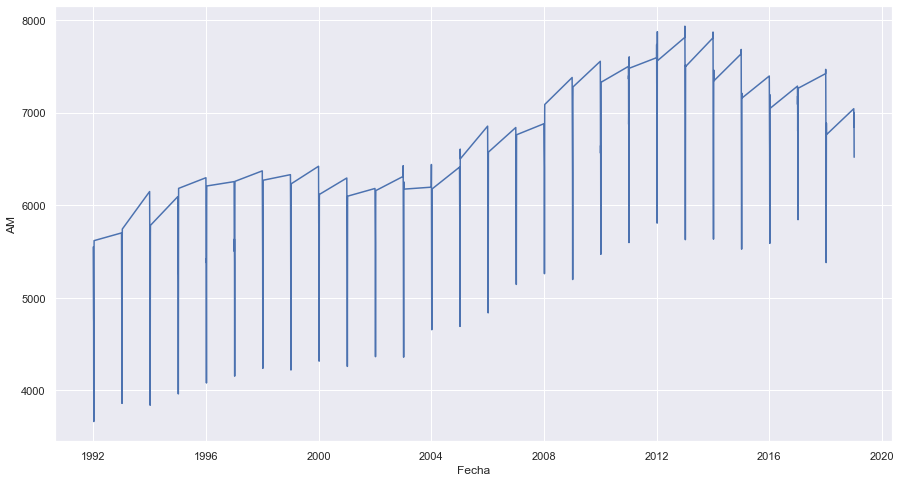

In [3]:
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.lineplot(x='Fecha', y='AM', data=df)

Dos formas de corregirlo:

In [4]:
#Reimportando datos
df = pd.read_csv("TimeSeries.csv", delimiter = ";")

df["Fecha2"] = df["Fecha"].apply(lambda x: datetime.strptime(x, '%d/%m/%Y'))

Otra forma de corregirlo:

In [5]:
#Reimportando datos
df = pd.read_csv("TimeSeries.csv", delimiter = ";")
df["Fecha"] = pd.to_datetime(df["Fecha"],format="%d/%m/%Y")
df.set_index("Fecha", inplace=True)

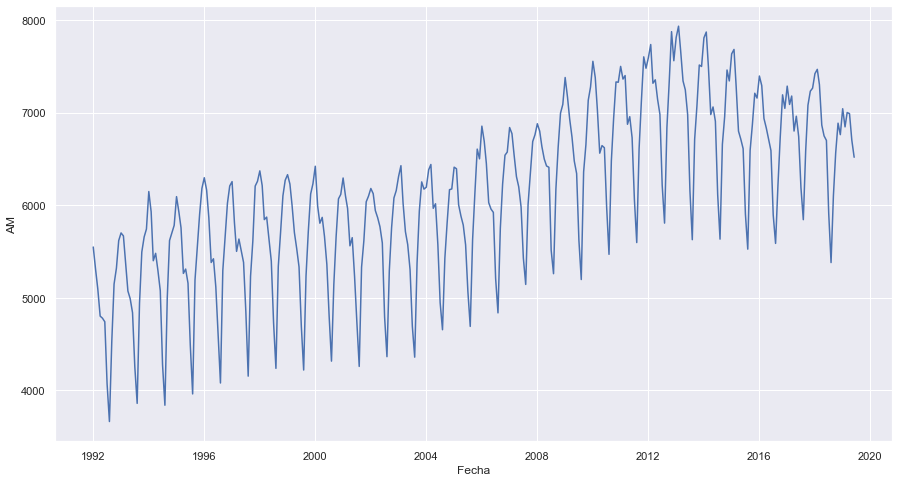

In [6]:
ax = sns.lineplot(x = df.index, y = 'AM', data=df)

Graficando con altair:

In [7]:
#Altair no reconoce los índice, así que hay que hacer un reset_index antes
alt.Chart(df.reset_index()).mark_line().encode(
    x="Fecha", y="AM"
    ).properties(
        width=1000,
        height=300
).interactive()

alt.Chart(...)

## Análisis de la Serie Temporal.

Para empezar, se va a descomponer la serie temporal.

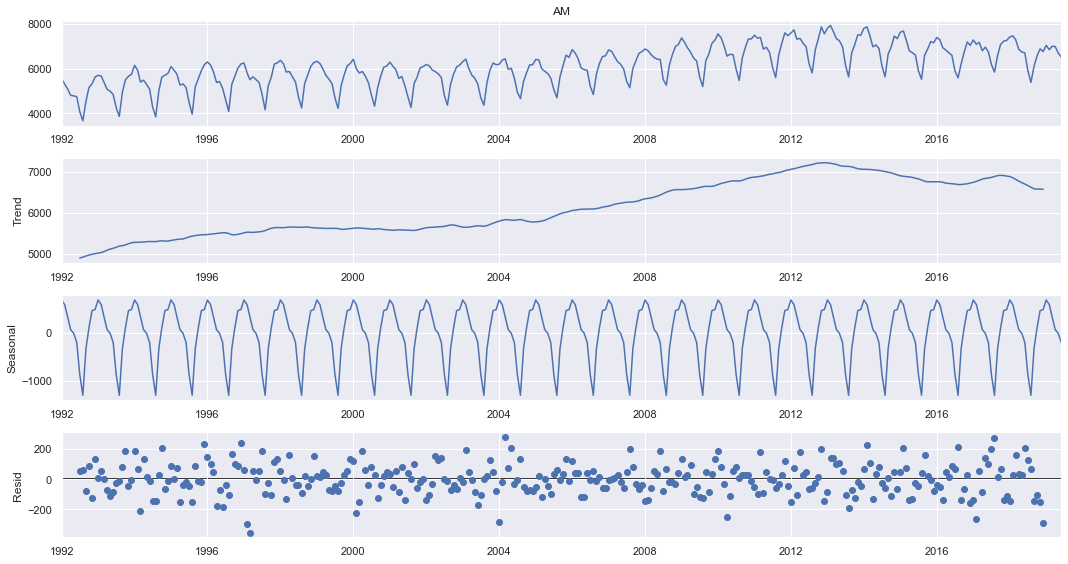

In [8]:
res = sm.tsa.seasonal_decompose(df["AM"], model = "additive")
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

La serie parece tener tendencia y estacionalidad, vamos a ver en detalla el ACF y PACF.

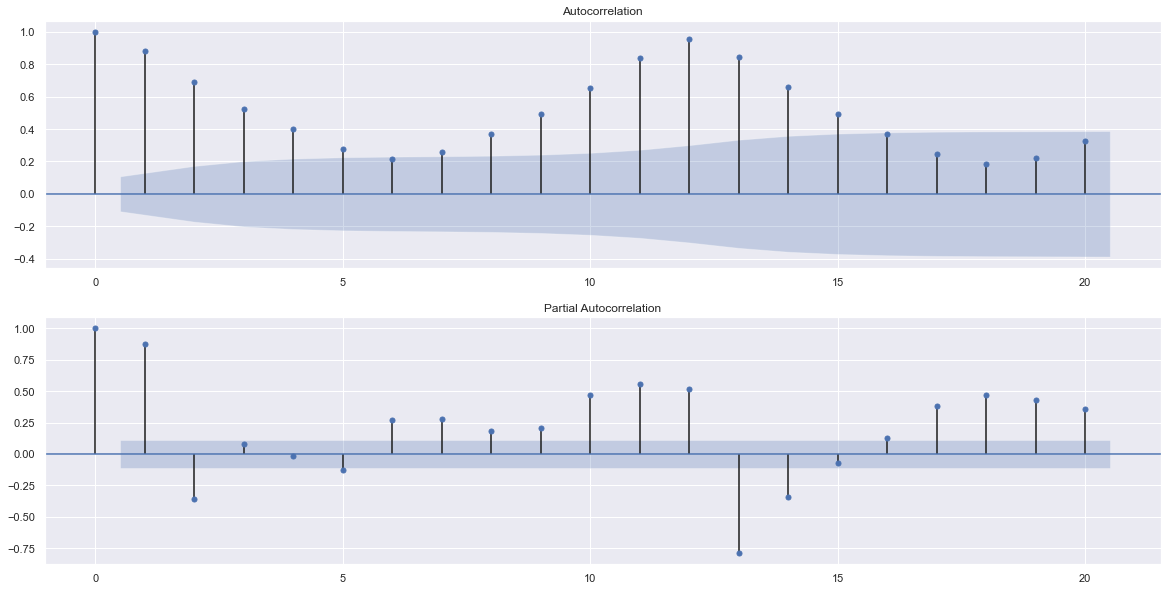

In [9]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(df, lags=20, adjusted=True, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(df, lags=20, ax=ax[1])
plt.show()

Para comprender **ACF** y **PACF** hay que comprender que es ARIMA.

**ARIMA** viene de *Auto Regressive Integrated Moving Average*. Que sea autorregresivo parte de la idea de que utiliza sus propios lags como predictores de valores futuros. Los modelos de regresión trabajan mejor cuando los predictores no están correlacionados y son independientes unos de otros. Por ello, es importante conseguir que la serie temporal no tenga tendencia, sea homocedástica y no tenga autocorrelación.

Los órdenes de ARIMA son (p,d,q), de ahí su nombre, ya que AR(p), I(d), MA(q). 'P' es el orden de la parte autorregresiva y se refiere al número de lags de Y que se utilizarán como predictores y 'q' se refiere al número de retardos de error de predicción que se incluirán en el modelo. 'd' es el número de diferencias regulares que se deben tomar para hacer estacionaria la serie. Así, una diferencia regular equivale a un d=1. Esto se verá más adelante.

El orden de AR(p) se puede comprobar en la PACF y el orden de MA(q) en la ACF.

### PACF

PACF puede ser entendida como la correlación entre la serie y sus lags excluyendo el impacto de los lags intermedios, es decir, es la correlación pura entre un lag y las series. PACF muestra el orden de AR(p)

En el gráfico de arriba vemos tres palos significativos en la PACF, siendo el primero la correlación con el mismo, por eso es igual a uno. PACF en la serie sin diferenciar debería ser 2. Por lo tanto AR(2).

### MA

Igual que el orden AR(p) se puede ver en PACF, el orden MA(q) se puede ver en ACF. Este es el error de los lagged forecast.

En la serie sin tomar diferencias sería MA(5)

### ADF

Como se ha explicado, el objetivo de diferenciar es hacer la serie estacionaria e indica la magnitud de 'd'. Solo se necesita diferenciar una serie no-estacionaria, si es estacionaria, no debe diferenciarse.

Hay que tener cuidado con no sobrediferenciar la serie, ya que esto afectaría a los parámetros del modelo. La magnitud idónea de 'd' es la mínima que consigue que la serie temporal sea estacionaria y la ACF alcanza un valor de cero rápidamente. Si a serie tiene autocorrelaciones positivas durante muchos rezagos o lags (10 o más), la serie necesita ser diferenciada. Por el contrario, si el lag 1 de autocorrelación es muy negativo, es probable que la serie se encuentre sobrediferenciada. Hay más información en este enlace [enlace](https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/).

Para comprobar si una serie es estacionaria, que como se ha comentado es el objetivo, se suele hacer el test de raíz unitaria ADF o Augmented Dickey Fuller.

Este test busca determinar la existencia de o no de raíces unitarias en la serie (la hipótesis nula de este test es que existe una raíz unitaria, es decir, que la serie no es estacionaria).

El primer elemento es la estadística del test: cuanto más negativo, más probablemente la serie será estacionaria.

El segundo elemento es el p-value: la probabilidad del estadístico en estudio. Si es menor que 0.05, podemos rechazar la hipótesis nula y asumir que la serie temporal es estacionaria.

Los últimos valores son los valores críticos: los p-values para diferentes intervalos de confianza.

En cualquier caso, siempre es conveniente realizar un análisis visual de los datos, mostrándolos en una gráfica.

In [10]:
from statsmodels.tsa.stattools import adfuller

# ADF Test
adf = adfuller(df)
print(f"ADF P-value:{adf[1]}")

ADF P-value:0.4215706620275394


El test ADF devuelve que la serie no es estacionaria. Deberíamos tomar diferencias.

In [11]:
from pmdarima.arima.utils import ndiffs

## Adf Test
adf_n = ndiffs(df, test='adf')

# KPSS test
kpss_n = ndiffs(df, test='kpss')

# PP test:
pp_n = ndiffs(df, test='pp') 

print(f"ADF ndiffs: {adf_n}, KPSS ndiffs:{kpss_n}, pp ndiffs {pp_n}")

ADF ndiffs: 0, KPSS ndiffs:1, pp ndiffs 0


Los resultados obtenidos son diferentes. En base a lo observado, vamos a probar con una diferencia.

In [12]:
df_diff = df.diff(1).dropna()

In [13]:
# ADF Test
adf = adfuller(df_diff)
print(f"ADF P-value:{adf[1]}")

ADF P-value:1.615094972498302e-07


En base a estos resultados, la serie ya sería estacionaria.

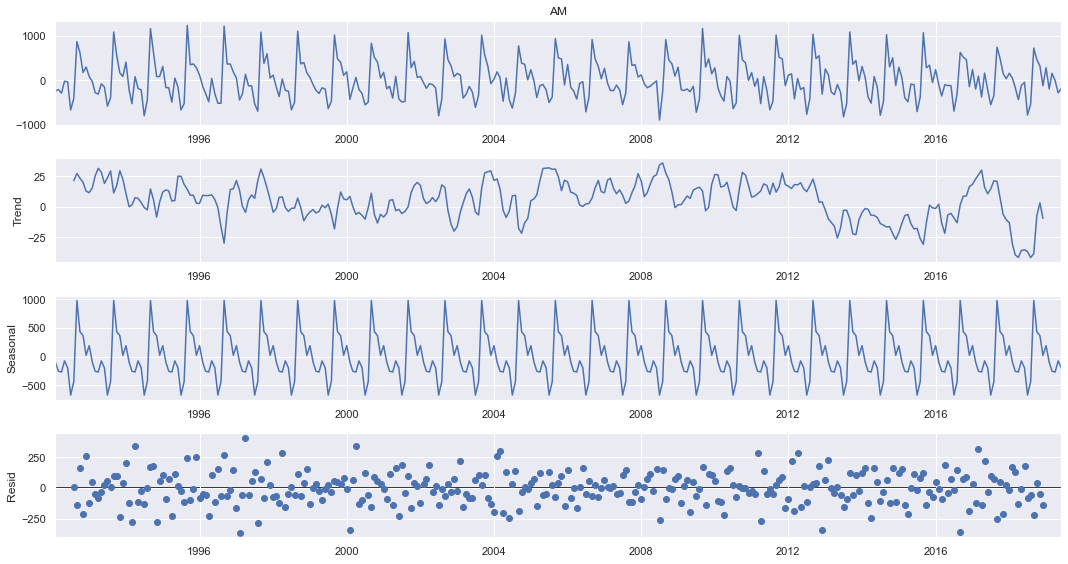

In [14]:
res = sm.tsa.seasonal_decompose(df_diff["AM"], model = "additive", period=12)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

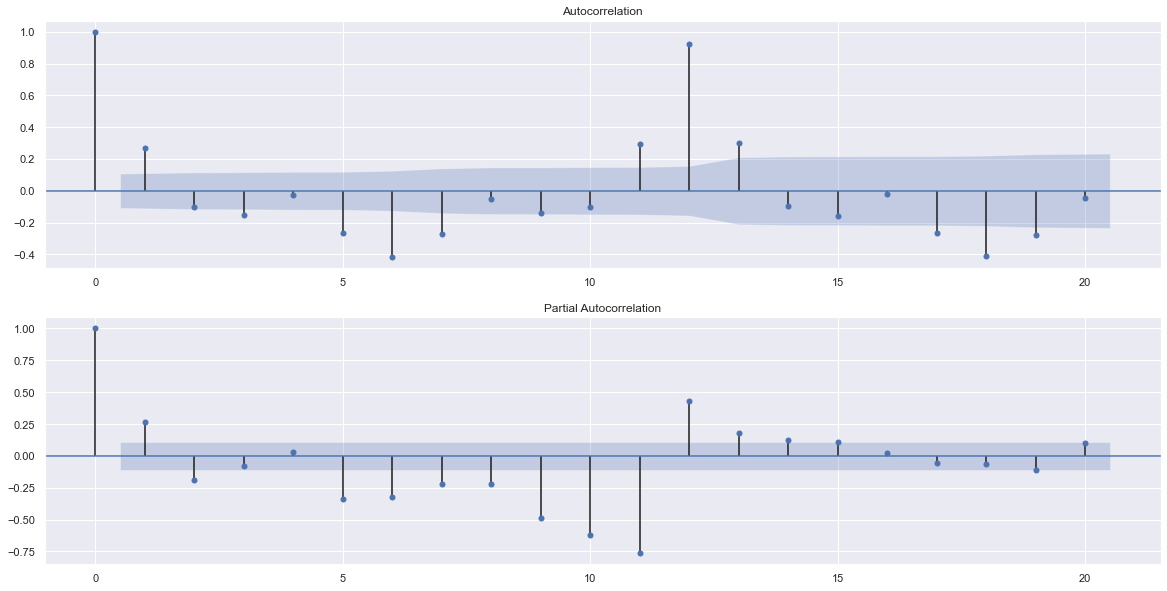

In [15]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(df_diff, lags=20, adjusted=True, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(df_diff, lags=20, ax=ax[1])
plt.show()

Con todo ello, parecería razonable pensar que el orden ARIMA es (2,1,1)

Se descompone la serie temporal:

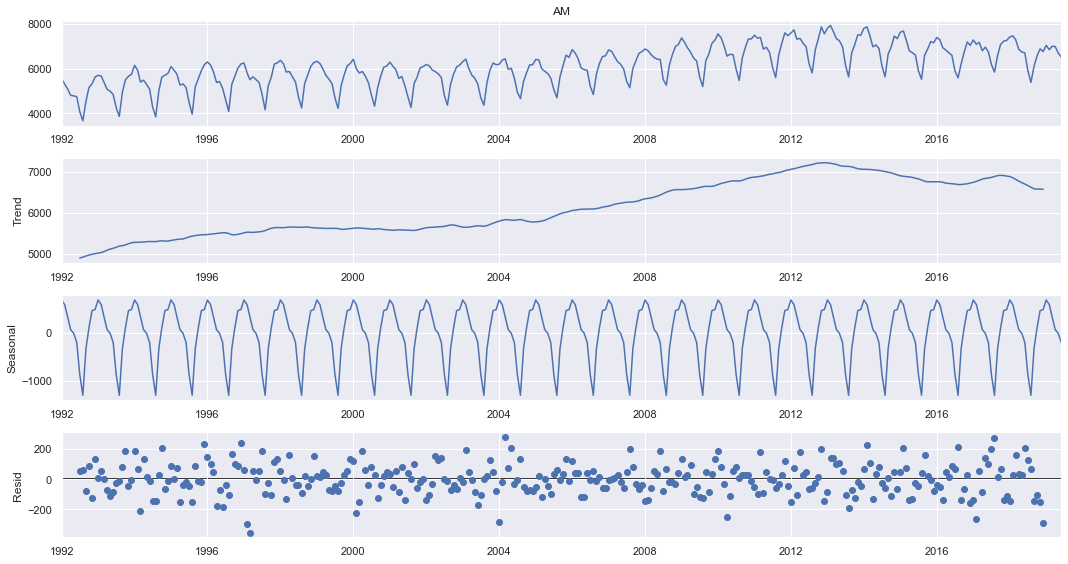

In [16]:
res = sm.tsa.seasonal_decompose(df["AM"], model = "additive", period=12)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

Se puede ver claramente que hay una tendencia

Se realiza un test de Dickey-Fuller de raíz unitaria. Su hipótesis nula es que la serie no es estacionaria.

In [17]:
# ADF Test
adf = adfuller(df, regression='ct', autolag='AIC')
print(f'ADF Statistic: {adf[0]}')
print(f'p-value: {adf[1]}')

ADF Statistic: -0.3619564074155549
p-value: 0.9879669099235677


In [18]:
from pmdarima.arima.utils import ndiffs

difs_adf = ndiffs(df, test = "adf")
difs_kpss = ndiffs(df, test = "kpss")
difs_pp = ndiffs(df, test = "pp")
print(difs_adf , difs_kpss , difs_pp)

0 1 0


In [19]:
#Se toman las diferencias
train_diff = df.diff(1).dropna()

#Se puede tomar de otra manera
train_diff_ = df - df.shift(1)
train_diff_.dropna()

,AM
Fecha,
1992-02-01,-244.0
1992-03-01,-210.0
1992-04-01,-292.0
1992-05-01,-22.0
1992-06-01,-39.0
...,...
2019-02-01,-196.0
2019-03-01,155.0
2019-04-01,-12.0


In [20]:
adf = adfuller(df.diff().dropna(), regression='c', autolag='AIC')
print(f'ADF Statistic: {adf[0]}')
print(f'p-value: {adf[1]}')

ADF Statistic: -6.005989548299289
p-value: 1.615094972498302e-07


In [21]:
adf = adfuller(df, regression='ct', autolag='AIC')
print(f'ADF Statistic: {adf[0]}')
print(f'p-value: {adf[1]}')


ADF Statistic: -0.3619564074155549
p-value: 0.9879669099235677


In [22]:
adf = adfuller(df.diff().dropna(), regression='c', autolag='AIC')
print(f'ADF Statistic: {adf[0]}')
print(f'p-value: {adf[1]}')

ADF Statistic: -6.005989548299289
p-value: 1.615094972498302e-07


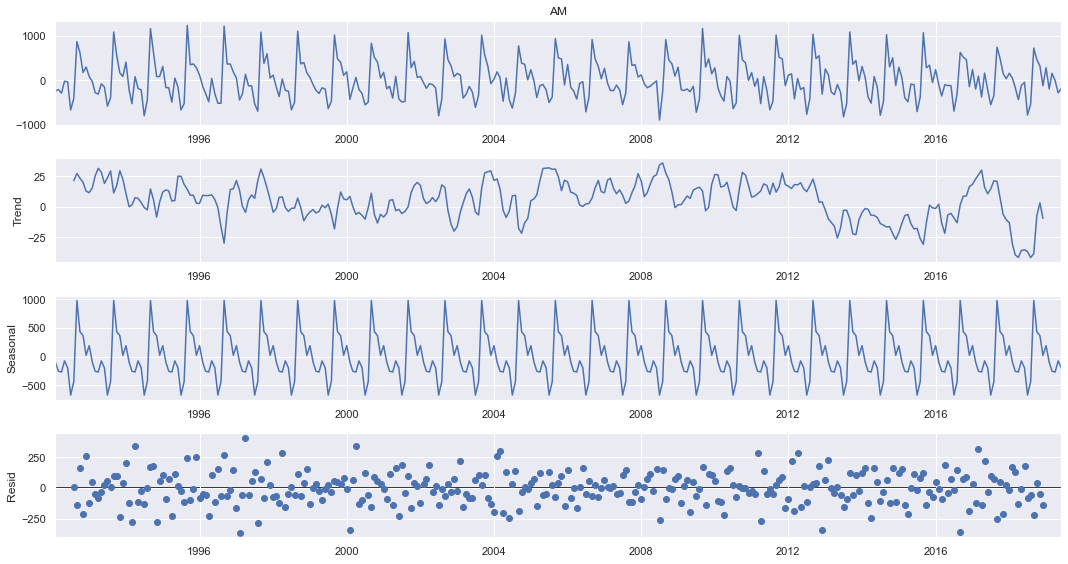

In [23]:
res = sm.tsa.seasonal_decompose(df["AM"].diff().dropna(), model = "additive", period=12)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

C:\Users\Jota_Moreno\Anaconda3\envs\tfm\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


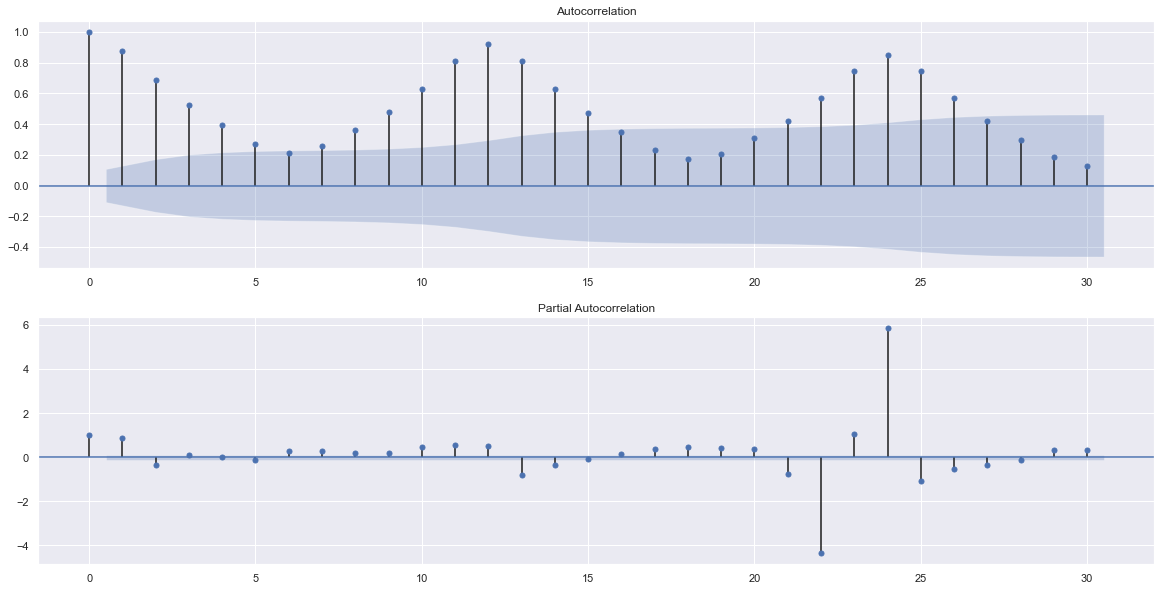

In [24]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(df, lags=30, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(df, lags=30, ax=ax[1])
plt.show()

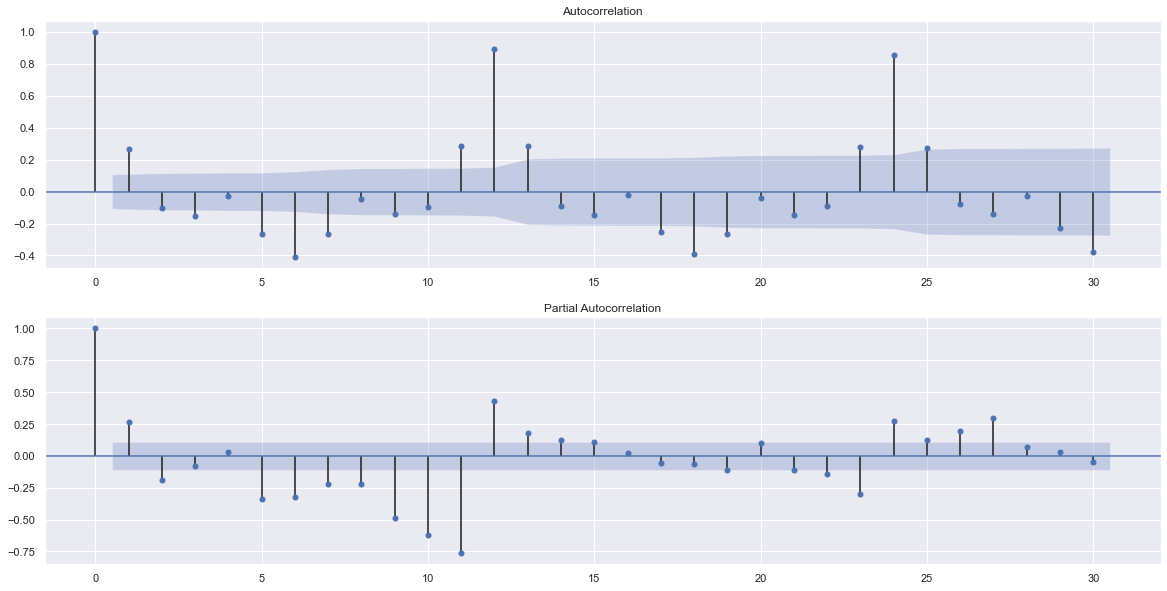

In [25]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(df.diff().dropna(), lags=30, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(df.diff().dropna(), lags=30, ax=ax[1])
plt.show()

Efectivamente, si se hace un auto_arima se ve que el orden recomendado es 2,1,2:

In [26]:
model = pm.auto_arima(df,suppress_warnings=True)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  330
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -2371.440
Date:                Sat, 12 Sep 2020   AIC                           4754.881
Time:                        18:20:39   BIC                           4777.657
Sample:                             0   HQIC                          4763.967
                                - 330                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.3838      1.371      1.010      0.313      -1.303       4.070
ar.L1          1.6249      0.029     56.564      0.000       1.569       1.681
ar.L2         -0.8847      0.028    -31.484      0.000      -0.940      -0.830
ma.L1         -1.8484      0.036    -51.779      0.000      -1.918      -1.778
ma.L2          0.9031      0.036     24.993      0.000       0.832       0.974
sigma2      1.048e+05   9090.762     11.533      0.000     8.7e+04    1.23e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.21
Prob(Q):                              0.99   Prob(JB):                         0.33
Heteroskedasticity (H):               1.06   Skew:                            -0.20
Prob(H) (two-sided):                  0.78   Kurtosis:                         2.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Y si se hace sobre a serie diferenciada, saldría ARIMA(2,0,2), ya que esta se encuentra ya diferenciada.

In [27]:
model = pm.auto_arima(df_diff,suppress_warnings=True)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  329
Model:               SARIMAX(2, 0, 2)   Log Likelihood               -2372.289
Date:                Sat, 12 Sep 2020   AIC                           4754.578
Time:                        18:20:48   BIC                           4773.558
Sample:                             0   HQIC                          4762.150
                                - 329                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6409      0.023     69.960      0.000       1.595       1.687
ar.L2         -0.9031      0.021    -42.386      0.000      -0.945      -0.861
ma.L1         -1.8455      0.036    -50.874      0.000      -1.917      -1.774
ma.L2          0.9129      0.037     24.865      0.000       0.841       0.985
sigma2      1.058e+05   9239.921     11.453      0.000    8.77e+04    1.24e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 0.88
Prob(Q):                              0.78   Prob(JB):                         0.64
Heteroskedasticity (H):               1.02   Skew:                            -0.12
Prob(H) (two-sided):                  0.91   Kurtosis:                         2.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Valoración:

Si se atiende al p-valor de summary, se ve que todos los elementos menos el intercepto son significativos. Sin embargo AIC y BIC son mejorables.

AIC y BIC nos permiten estimar la corrección del modelo:

- **AIC** (**Akaike Information Criterion**) es una métrica que nos indica cuán bueno o malo es nuestro modelo. Cuanto mejores predicciones realice un modelo, menos AIC tendrá. Aun cuando frecuentemente un mayor orden en el modelo puede suponer mejores predicciones, lo normal es que sea a costa de sobreentrenarlo, por lo que AIC impone una penalización a los modelos de alto orden (es decir, a aquellos con muchos parámetros).

- **BIC** (**Bayesian Information Criterion**) es una métrica semejante a AIC: cuanto mejor sea el modelo, menor BIC obtendrá. BIC también penaliza los modelos más complejos, y lo hace más que AIC, por lo que BIC tenderá a sugerir el uso de modelos más simples que AIC. En la mayor parte de los casos el modelo sugerido será el mismo pero, cuando no lo sea, deberemos escoger:

* Si buscamos el mejor modelo predictivo, AIC será más aconsejable.
* Si, por el contrario, buscamos un modelo que explique de forma más sencilla nuestros datos, nos decantaremos por BIC.

### Quitando la estacionalidad

La mejor manera de observar la estacionalidad es ver patrones que se repiten en la ACF en la parte estacional (por ejemplo, cada 12, 24, 36... meses).

Se debe tener cuidado ya que estos patrones muchas veces son inapreciables e influyen enormemente en los resultados. Esta estacionalidad se puede ver claramente en la parte estacional:

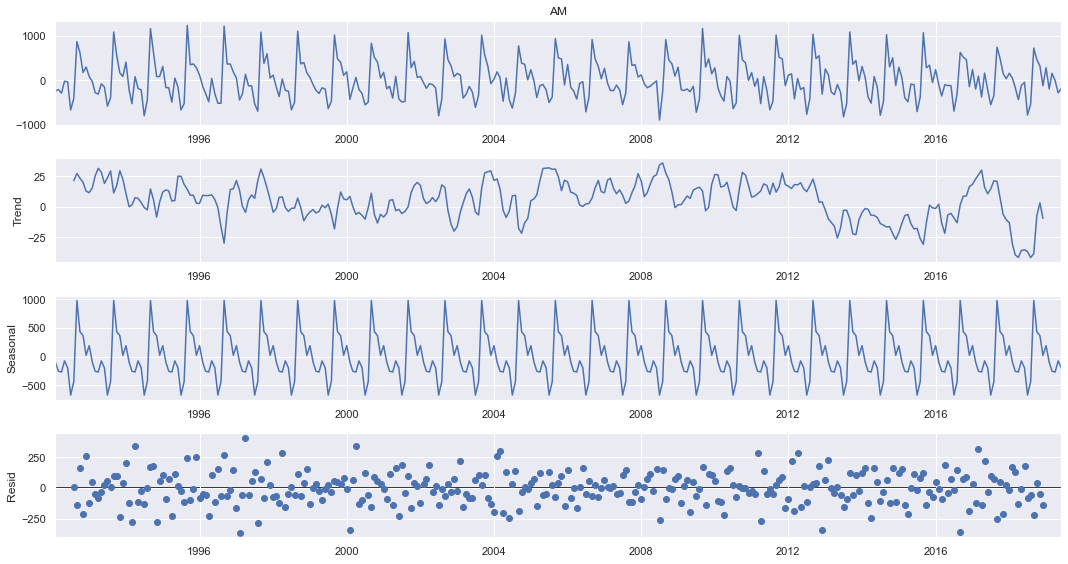

In [28]:
res = sm.tsa.seasonal_decompose(df["AM"].diff().dropna(), model = "additive", period=12)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

El problema del modelo anterior, un ARIMA, es que no soporta la estacionalidad, cuando la serie tiene claramente estacionalidad. Como regla general, D en la parte estacional jamás debe exceder 1 y 'd + D' nunca debe exceder 2.

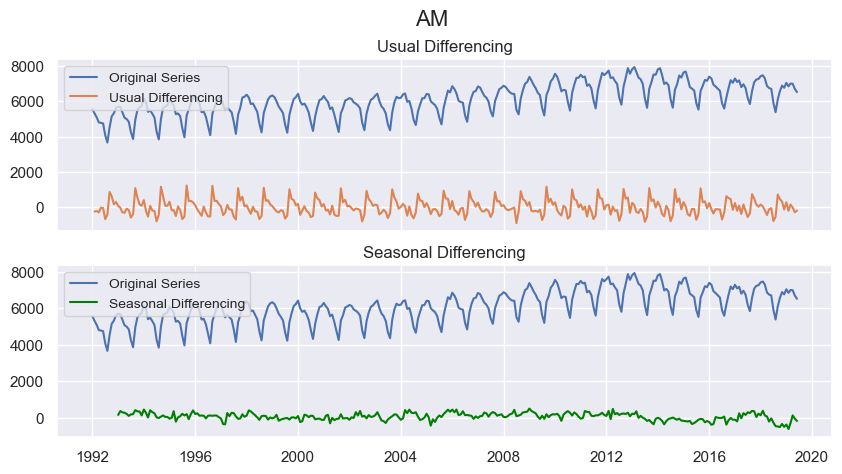

In [29]:
# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(df[:], label='Original Series')
axes[0].plot(df[:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasinal Dei
axes[1].plot(df[:], label='Original Series')
axes[1].plot(df[:].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('AM', fontsize=16)
plt.show()

Para evaluar si existe estacionalidad, se suele utilizar el CHTest.

In [30]:
from pmdarima.arima import CHTest
from pmdarima.arima import nsdiffs

nsdiffs(df_diff, m=12)

0

Indica que no necesitaría diferenciación estacional, aunque tenga parte estacional.

Vamos a hacer un AutoArima testando ambas:

In [31]:
# Seasonal - fit stepwise auto-ARIMA
smodel_1 = pm.auto_arima(df, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=1, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel_1.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=3980.025, Time=0.67 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4168.730, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4059.941, Time=0.30 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=3986.717, Time=0.63 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=4102.271, Time=0.21 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=3981.063, Time=1.36 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=3981.152, Time=1.27 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=4032.286, Time=0.38 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=inf, Time=2.26 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=4004.419, Time=0.54 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=3981.436, Time=1.06 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=3981.782, Time=1.62 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=4039.050, Time=0.27 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=3982.374, Time=0.73 sec
 ARIMA(2,1,0)(0,1,1)[12]

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  330
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1986.013
Date:                            Sat, 12 Sep 2020   AIC                           3980.025
Time:                                    18:21:04   BIC                           3995.061
Sample:                                         0   HQIC                          3986.031
                                            - 330                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3114      0.083      3.740      0.000       0.148       0.475
ma.L1         -0.7584      0.057    -13.249      0.000      -0.871      -0.646
ma.S.L12      -0.8031      0.046    -17.407      0.000      -0.894      -0.713
sigma2      1.555e+04   1242.309     12.520      0.000    1.31e+04     1.8e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 7.18
Prob(Q):                              0.82   Prob(JB):                         0.03
Heteroskedasticity (H):               1.27   Skew:                             0.33
Prob(H) (two-sided):                  0.22   Kurtosis:                         3.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(df, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=1, D=0, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.84 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=4941.411, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.74 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=4693.357, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=4939.427, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=4914.023, Time=0.05 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=4180.770, Time=1.02 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=4297.113, Time=0.76 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=inf, Time=1.50 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=4194.887, Time=2.39 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=4584.226, Time=1.10 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=4230.490, Time=1.42 sec
 ARIMA(0,1,1)(2,0,2)[12] intercept   : AIC=inf, Time=2.89 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=4224.234, Time=0.92 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  330
Model:             SARIMAX(0, 1, 3)x(1, 0, [1], 12)   Log Likelihood               -2078.065
Date:                              Sat, 12 Sep 2020   AIC                           4168.130
Time:                                      18:22:05   BIC                           4190.906
Sample:                                           0   HQIC                          4177.216
                                              - 330                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4283      0.049     -8.741      0.000      -0.524      -0.332
ma.L2         -0.1034      0.054     -1.912      0.056      -0.209       0.003
ma.L3         -0.1318      0.055     -2.392      0.017      -0.240      -0.024
ar.S.L12       0.9978      0.001    797.216      0.000       0.995       1.000
ma.S.L12      -0.7869      0.047    -16.709      0.000      -0.879      -0.695
sigma2      1.555e+04   1254.831     12.394      0.000    1.31e+04     1.8e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 6.10
Prob(Q):                              0.83   Prob(JB):                         0.05
Heteroskedasticity (H):               1.12   Skew:                             0.32
Prob(H) (two-sided):                  0.56   Kurtosis:                         3.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Se obtiene un mejor AIC con D = 1

### Out of time Cross-Validation

Con Out Of Time Cross-Validation hacemos un train_test_spit e intentamos predecir datos que ya sabemos para comaprar con los actuales y ver cómo de buena es nuestra precisión.

Para hacerlo hay que crear un training y un test dataset dividiéndolos en dos periodos de tiempo contiguos, de en torno a una relación 75:25.

In [34]:
df

,AM
Fecha,
1992-01-01,5548
1992-02-01,5304
1992-03-01,5094
1992-04-01,4802
1992-05-01,4780
...,...
2019-02-01,6845
2019-03-01,7000
2019-04-01,6988


In [39]:
train_size = int(len(df)*0.85)

train = df.iloc[:train_size,:]
test = df.iloc[train_size:,:]

In [41]:
smodel

ARIMA(order=(0, 1, 3), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [42]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train, order=(0, 1, 2), scoring_args={}, seasonal_order=(1, 0, 1, 12)).fit()
model.summary()

#Elaboro la predicción
prediction = model.get_forecast(steps = 24)
forecast = model.forecast(24)

#Obtengo los intervalos de confianza
lower_ci = prediction.conf_int().iloc[:,0]
upper_ci = prediction.conf_int().iloc[:,1]

#Hago la predicción sobre datos pasados
fitted_model = model.fittedvalues

C:\Users\Jota_Moreno\Anaconda3\envs\tfm\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Jota_Moreno\Anaconda3\envs\tfm\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


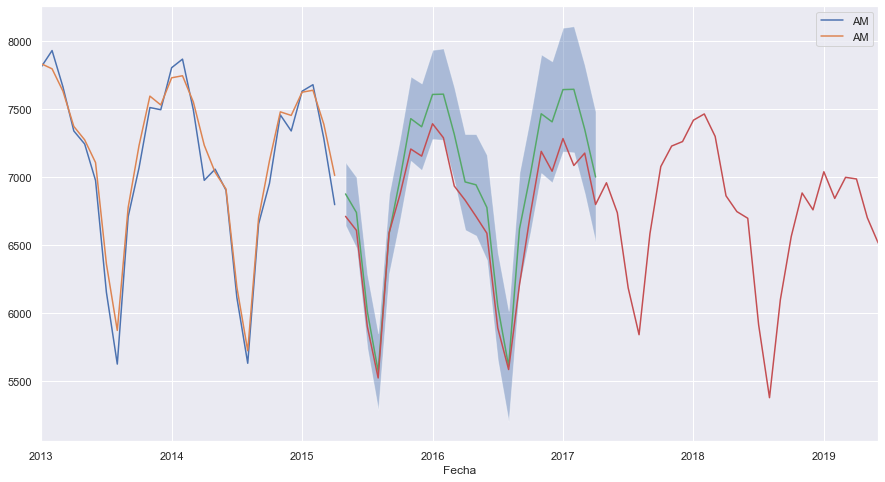

In [45]:
#Con truncate quito del eje los periodos anteriores al 2000
fig, ax = plt.subplots()
train.truncate(before = "2013").plot(ax = ax)
fitted_model.truncate(before = "2013").plot(ax = ax)
forecast.plot(ax = ax)
test.plot(ax = ax)
ax.fill_between(lower_ci.index, lower_ci, upper_ci, alpha = 0.4)
plt.show()
plt.show()

Parece que se ajusta bien al pasado.

In [46]:
from sklearn.metrics import mean_squared_error
mean_squared_error(train.AM, model.fittedvalues)

137675.81406810132

In [47]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse,  
            'corr':corr, 'minmax':minmax})

In [48]:
forecast_accuracy(model.fittedvalues, train.AM)

{'mape': 0.023359476112527696,
 'me': -12.555458057181694,
 'mae': 131.77158630320466,
 'mpe': -0.0014866466345929846,
 'rmse': 371.0469162627568,
 'corr': 0.9216403777330985,
 'minmax': 0.022847447979428392}

Con el pasado tiene un MAPE del 2.33%, un buen resultado.

In [49]:
#Selecting the real data to compare with the forecast
test_ = test.iloc[:len(forecast),:]

In [50]:
forecast_accuracy(forecast, test_.AM)

{'mape': 0.032270985111680965,
 'me': 220.49237421808093,
 'mae': 221.11244755691072,
 'mpe': 0.03217690631653155,
 'rmse': 255.85904559113345,
 'corr': 0.9826125030043186,
 'minmax': 0.030960885999469112}

El MAPE de la preddición es del 3,22%

Se va a probar con el otro modelo:

In [51]:
smodel_1

ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(0, 1, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [52]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train, order=(1, 1, 1), scoring_args={}, seasonal_order=(0, 1, 1, 12)).fit()
model.summary()

#Elaboro la predicción
prediction = model.get_forecast(steps = 24)
forecast = model.forecast(24)

#Obtengo los intervalos de confianza
lower_ci = prediction.conf_int().iloc[:,0]
upper_ci = prediction.conf_int().iloc[:,1]

#Hago la predicción sobre datos pasados
fitted_model = model.fittedvalues

C:\Users\Jota_Moreno\Anaconda3\envs\tfm\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Jota_Moreno\Anaconda3\envs\tfm\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


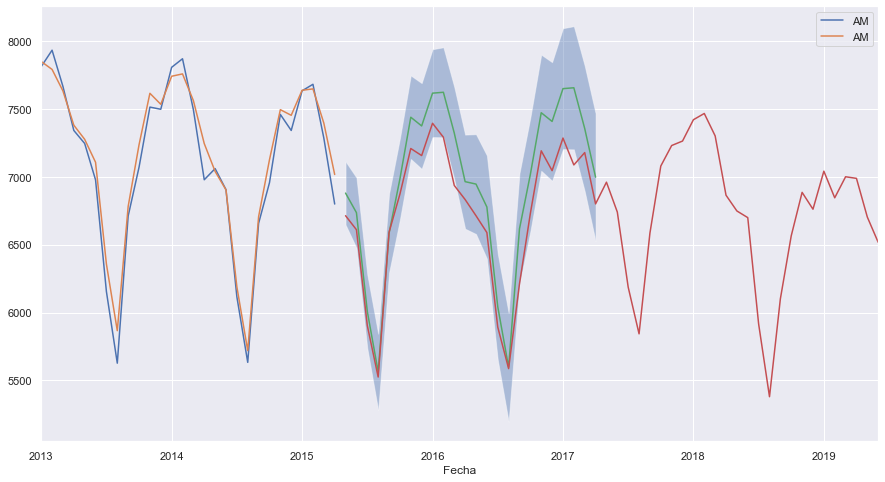

In [54]:
#Con truncate quito del eje los periodos anteriores al 2000
fig, ax = plt.subplots()
train.truncate(before = "2013").plot(ax = ax)
fitted_model.truncate(before = "2013").plot(ax = ax)
forecast.plot(ax = ax)
test.plot(ax = ax)
ax.fill_between(lower_ci.index, lower_ci, upper_ci, alpha = 0.4)
plt.show()
plt.show()

In [55]:
from sklearn.metrics import mean_squared_error
mean_squared_error(train.AM, model.fittedvalues)

157066.45915527822

In [56]:
forecast_accuracy(model.fittedvalues, train.AM)

{'mape': 0.023662215717674503,
 'me': -1.0451023918891338,
 'mae': 134.43991595638045,
 'mpe': 0.00021734324416399078,
 'rmse': 396.31611013845776,
 'corr': 0.9126522950117338,
 'minmax': 0.022751736159456692}

In [57]:
#Selecting the real data to compare with the forecast
test_ = test.iloc[:len(forecast),:]

In [58]:
forecast_accuracy(forecast, test_.AM)

{'mape': 0.03214807610755358,
 'me': 220.10491602573208,
 'mae': 220.74611563853284,
 'mpe': 0.03205079199090956,
 'rmse': 257.36267423763474,
 'corr': 0.9826417391589712,
 'minmax': 0.03082811727231738}

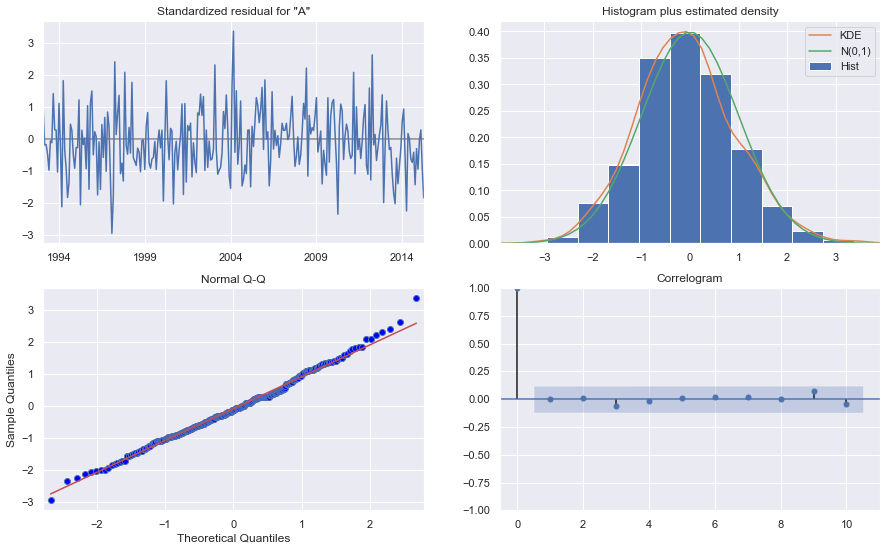

In [59]:
fig = model.plot_diagnostics()
fig.set_size_inches(15, 9)
plt.show()

In [60]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(df, order=(0, 1, 2), scoring_args={}, seasonal_order=(1, 0, 1, 12)).fit()
model.summary()

#Elaboro la predicción
prediction = model.get_forecast(steps = 24)
forecast = model.forecast(24)

#Obtengo los intervalos de confianza
lower_ci = prediction.conf_int().iloc[:,0]
upper_ci = prediction.conf_int().iloc[:,1]

#Hago la predicción sobre datos pasados
fitted_model = model.fittedvalues

C:\Users\Jota_Moreno\Anaconda3\envs\tfm\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Jota_Moreno\Anaconda3\envs\tfm\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


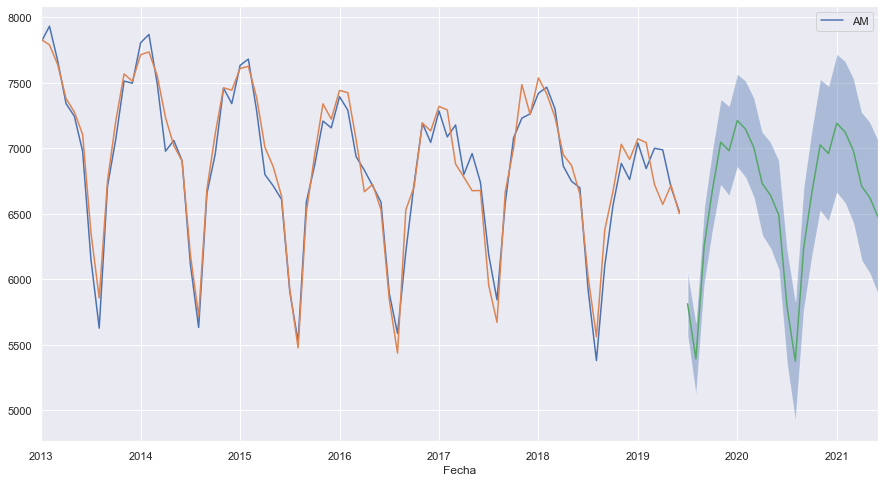

In [62]:
#Con truncate quito del eje los periodos anteriores al 2000
fig, ax = plt.subplots()
df.truncate(before = "2013").plot(ax = ax)
fitted_model.truncate(before = "2013").plot(ax = ax)
forecast.plot(ax = ax)
ax.fill_between(lower_ci.index, lower_ci, upper_ci, alpha = 0.4)
plt.show()
plt.show()